Training Images

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=16
CHANNELS=3
EPOCHS=55


In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("imagetrain",
shuffle=True,
seed=123,
image_size=(IMAGE_SIZE, IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 442 files belonging to 7 classes.


In [5]:
class_names= dataset.class_names
class_names

['Image Not Clear',
 'Tea leaf blight',
 'Tea red leaf spot',
 'Tea red scab',
 'algal-leaf-spot',
 'blister-blight',
 'healty-leaf']

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.75, val_split=0.13, test_split=0.14, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [10]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE ,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=7
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size= (3, 3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [12]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/55
21/21 [==============================] - 25s 1s/step - loss: 1.9069 - accuracy: 0.1818 - val_loss: 1.7455 - val_accuracy: 0.3125
Epoch 2/55
21/21 [==============================] - 29s 1s/step - loss: 1.7901 - accuracy: 0.2818 - val_loss: 1.7121 - val_accuracy: 0.2708
Epoch 3/55
21/21 [==============================] - 29s 1s/step - loss: 1.6091 - accuracy: 0.3667 - val_loss: 1.6226 - val_accuracy: 0.3542
Epoch 4/55
21/21 [==============================] - 30s 1s/step - loss: 1.5248 - accuracy: 0.3121 - val_loss: 1.5782 - val_accuracy: 0.3750
Epoch 5/55
21/21 [==============================] - 29s 1s/step - loss: 1.4319 - accuracy: 0.3788 - val_loss: 1.3731 - val_accuracy: 0.4792
Epoch 6/55
21/21 [==============================] - 29s 1s/step - loss: 1.3339 - accuracy: 0.4606 - val_loss: 1.1690 - val_accuracy: 0.5000
Epoch 7/55
21/21 [==============================] - 31s 1s/step - loss: 1.2607 - accuracy: 0.5000 - val_loss: 1.3216 - val_accuracy: 0.4583
Epoch 8/55
21/21 [==

In [14]:
scores=model.evaluate(test_ds)

4/4 [==============================] - 4s 341ms/step - loss: 0.1784 - accuracy: 0.8906


In [15]:
history

In [16]:
history.params

{'verbose': 1, 'epochs': 55, 'steps': 21}

In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [18]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']
loss = history.history['loss']
val_loss=history.history['val_loss']

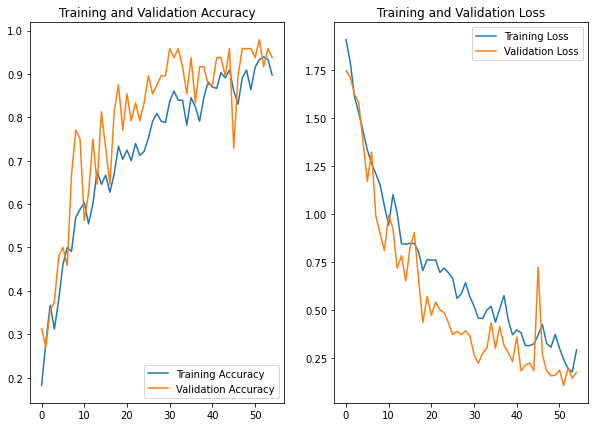

In [23]:
import numpy as np

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array, 0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence


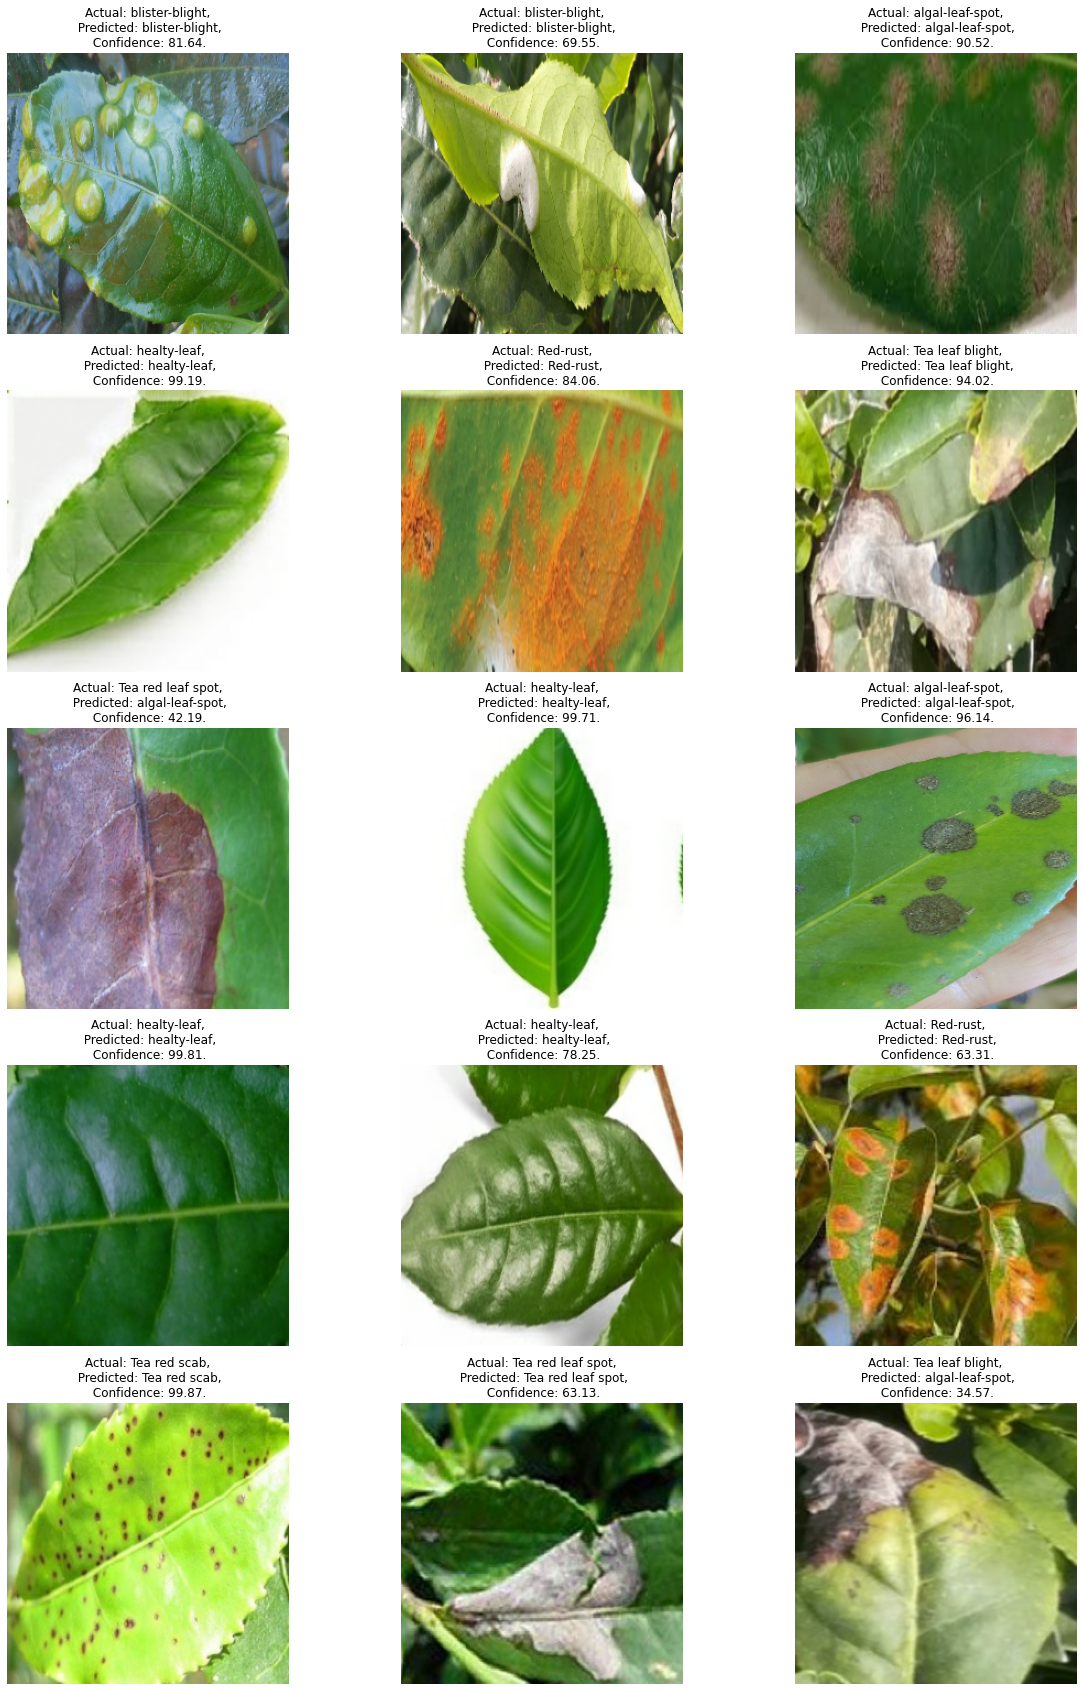

In [ ]:
plt.figure(figsize=(20, 30))
for images, labels in test_ds.take(1):
    for i in range(15):
        ax=plt.subplot(5, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence= predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}.")
        plt.axis("off")

In [ ]:
model.save(f"../saved_models/test1")

INFO:tensorflow:Assets written to: ../saved_models/test1\assets


In [ ]:
model.save(f"../saved_models/test1.h5")